##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [344]:
# %pip install -r reqs.txt
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

## Imports

In [345]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import itertools

RANDOM_SEED = 42

In [346]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/datathon.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

# Life and Health Insurance Purchase Prediction: Unraveling Client Intentions with Machine Learning


Authors: Au Jun Hui, Wang Jiayi, Wilson Widyadhana, Wong Zhi Yuan

## Table of Contents
1. [Table of Contents](#table-of-contents)
2. [Loading the dataset and a cursory glance](#loading-the-dataset-and-a-cursory-glance)
3. [Feature Selection Based on Domain Knowledge](#feature-selection-based-on-domain-knowledge)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
5. [Splitting of Dataset + Feature Engineering](#splitting-of-dataset--feature-engineering)
6. [Modelling](#modelling)
7. [Conclusion](#conclusion)

## Loading the dataset and a cursory glance

In [347]:
initial_df = pd.read_parquet(filepath)

In [ ]:
print("Number of rows: ", initial_df.shape[0])
print("Number of columns: ", initial_df.shape[1])
display(initial_df)
initial_df.info()

In [ ]:
initial_df.describe()

In [350]:
# Check for NaN values and the number of unique values
print("Are there any NaN values: ", initial_df.isnull().values.any())
# Count the number of NaN values in each column
nan_count_per_column = initial_df.isnull().sum()

# Display the count of NaN values
print("Number of NaN values in each column:")
print(nan_count_per_column)

Are there any NaN values:  True
Number of NaN values in each column:
clntnum                         0
race_desc                    3996
ctrycode_desc                  20
clttype                         0
stat_flag                       0
                            ...  
flg_gi_claim_29d435_ever    17992
flg_gi_claim_058815_ever    17992
flg_gi_claim_42e115_ever    17992
flg_gi_claim_856320_ever    17992
f_purchase_lh               17282
Length: 304, dtype: int64


In [351]:
# Identify and print columns with all NaN values
all_nan_columns = nan_count_per_column[nan_count_per_column == len(initial_df)]
print("Columns with all NaN values:")
print(all_nan_columns.index.tolist())

Columns with all NaN values:
['giclaim_cnt_success', 'recency_giclaim_success', 'giclaim_cnt_unsuccess', 'recency_giclaim_unsuccess', 'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever']


In [352]:
# Look at the target column
print(f"Numer of NaN values in the target column: {nan_count_per_column['f_purchase_lh']}")

Numer of NaN values in the target column: 17282


In [353]:
initial_df['f_purchase_lh'].value_counts()

f_purchase_lh
1.0    710
Name: count, dtype: int64

## Feature Selection Based on Domain Knowledge

Given the extensive dataset with 304 columns, we aim to streamline our features by excluding those we believe may not significantly contribute to predicting whether a customer will purchase life or health insurance products in the next three months. Our decision to remove specific columns is grounded in domain knowledge and a focus on enhancing model interpretability and performance.

Columns to be removed and their corresponding rationale:


| Column Name | Column Details                                | Reason for Removal                                                                  |
|----------|-----------------------------------------------|-------------------------------------------------------------------------------------|
| `clntnum`  | Unique identifier for the client.             | ID column, no relation to the target feature                                        |
| `is_valid_dm` | Flags indicating the validity of direct mail. | Validity shouldn't be a predictor of whether a customer will purchase in the future |
| `is_valid_email`| Flags indicating the validity of addresses.   | Validity shouldn't be a predictor of whether a customer will purchase in the future |
| `giclaim_cnt_success`| Health and general insurance claim-related metrics.                                              | All columns are NaN                                                                 |
| `recency_giclaim_success`| Health and general insurance claim-related metrics.                                              | All columns are NaN                                                                 |
| `giclaim_cnt_unsuccess`| Health and general insurance claim-related metrics.                                              | All columns are NaN                                                                 |
| `recency_giclaim_unsuccess`| Health and general insurance claim-related metrics.                                              | All columns are NaN                                                                 |
| `flg_gi_claim_29d435_ever`| Flags for specific types of health and general insurance claims, with anonymized identifiers.                                              | All columns are NaN                                                                                     |
| `flg_gi_claim_058815_ever`| Flags for specific types of health and general insurance claims, with anonymized identifiers.                                              | All columns are NaN                                                                                     |
| `flg_gi_claim_42e115_ever`| Flags for specific types of health and general insurance claims, with anonymized identifiers.                                              | All columns are NaN                                                                                     |
| `flg_gi_claim_856320_ever`| Flags for specific types of health and general insurance claims, with anonymized identifiers.                                              | All columns are NaN                                                                                     |


These exclusions are made with the intention of simplifying the model without compromising predictive accuracy. The retained features will be those we deem most relevant and indicative of customer behavior regarding life and health insurance purchases.

## Exploratory Data Analysis (EDA)

We will now start incorporating visualizations and posing relevant questions to uncover potential insights.

### Extracting the labelled data

Since the dataset has only 700+ rows of labelled data, we find the need to perform data imputations. We first extract that dataset.

In [ ]:
labelled_df = initial_df[~initial_df['f_purchase_lh'].isnull()]
unlabelled_df = initial_df[initial_df['f_purchase_lh'].isnull()]
labelled_df.head()

In [355]:
print(labelled_df[['f_purchase_lh']].nunique())

f_purchase_lh    1
dtype: int64


As seen from above, it is evident that all labeled rows indicate the customer's intention to purchase life or health insurance products in the next three months. This uniformity in labels poses a challenge for utilizing algorithms such as K-Nearest Neighbors or Label Propagation to assign labels to previously unlabeled data points. 

Additionally, an observation reveals that in columns related to months, such as 'n_months_since_lapse_inv_dcd836,' there are instances where the values are 9999. This seems to be erroneous data.

For both these issues, we plan to address them in the subsequent `Splitting of Dataset + Feature Engineering` section, where we will outline our strategy for handling these gaps in the data.

### Visualizations

In [356]:
# Helper function for Bar Charts
def plot_bar_chart(df_column1, df_column2=None, x_label='', y_label='', title='', dataset1_label='Dataset 1', dataset2_label='Dataset 2', whole_numbers_only=False, count_labels=True, as_percentage=True):
    sns.set_theme()
    # Exclude None values from the first column
    df_column1 = df_column1[df_column1.notnull()]

    if df_column2 is not None:
        # Exclude None values from the second column
        df_column2 = df_column2[df_column2.notnull()]

    if whole_numbers_only:
        df_column1 = df_column1[df_column1 % 1 == 0]
        if df_column2 is not None:
            df_column2 = df_column2[df_column2 % 1 == 0]

    unique_categories = pd.Series(np.union1d(df_column1.unique(), df_column2.unique()))

    plt.figure(figsize=(12, 8))

    # Plot bars for the first column
    y1 = df_column1.value_counts(normalize=True).reindex(unique_categories, fill_value=0) * 100
    x1 = np.arange(len(unique_categories))
    width = 0.4  # Width of each bar

    plt.bar(x1, y1, width=width, color='blue', alpha=0.5, label=dataset1_label)

    if df_column2 is not None:
        # Plot bars for the second column
        y2 = df_column2.value_counts(normalize=True).reindex(unique_categories, fill_value=0) * 100
        x2 = np.arange(len(unique_categories)) + width  # Shift the x-coordinates for the second column
        plt.bar(x2, y2, width=width, color='orange', alpha=0.5, label=dataset2_label)

    plt.xticks(np.arange(len(unique_categories)) + width / 2, unique_categories)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    if count_labels:
        df_col1 = df_column1.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
        for idx in range(len(unique_categories)):
            category = unique_categories[idx]
            value = y1.get(category, 0)
            if as_percentage == False:
                plt.annotate(f'{value:.2f}%\n', xy=(x1[idx], value), ha='center', va='center')
            else:
                plt.annotate(f'{df_col1.get(category, 0)}\n', xy=(x1[idx], value), ha='center', va='center')

        if df_column2 is not None:
            df_col2 = df_column2.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
            for idx in range(len(unique_categories)):
                category = unique_categories[idx]
                value = y2.get(category, 0)
                if as_percentage == False:
                    plt.annotate(f'{value:.2f}%\n', xy=(x2[idx], value), ha='center', va='center')
                else:
                    plt.annotate(f'{df_col2.get(category, 0)}\n', xy=(x2[idx], value), ha='center', va='center')

    plt.show()

### Visualization 1: Distribution of Race

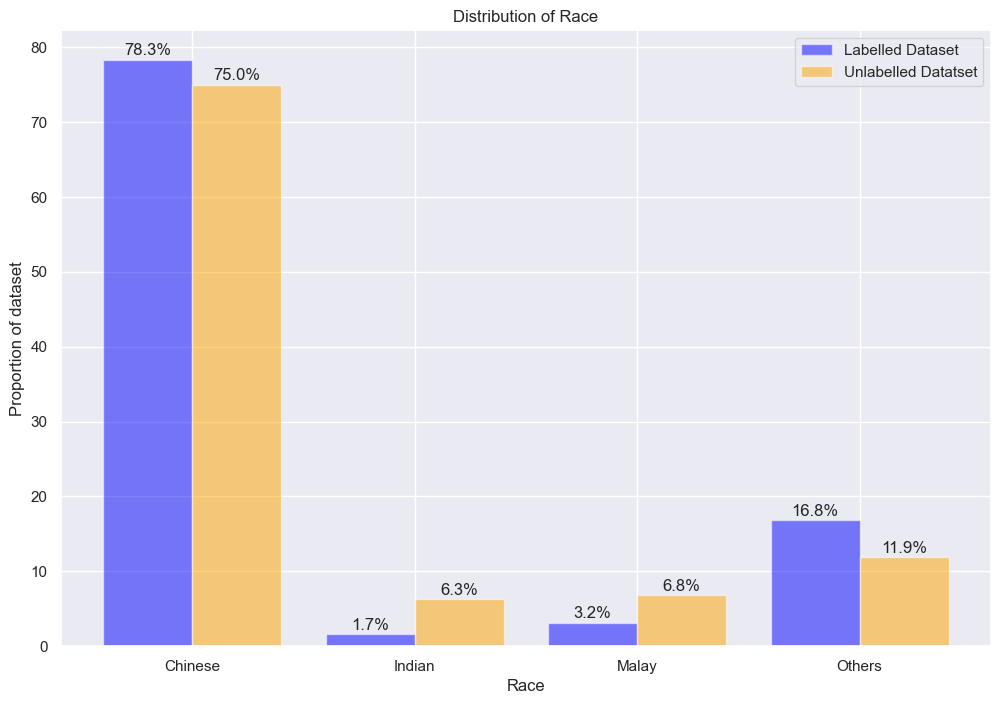

In [357]:
# Labelled Dataset
plot_bar_chart(labelled_df['race_desc'],unlabelled_df['race_desc'], 'Race', 'Proportion of dataset', 'Distribution of Race', dataset1_label='Labelled Dataset', dataset2_label='Unlabelled Datatset', whole_numbers_only = False, count_labels=True)

Based on the earlier observations, the racial composition in the dataset seems to align fairly well with Singapore's racial demographics. However, it's noteworthy that the second-largest category is labeled as 'Others,' which might warrant further investigation or clarification.

### Visualization 2: Distribution of Annual Income

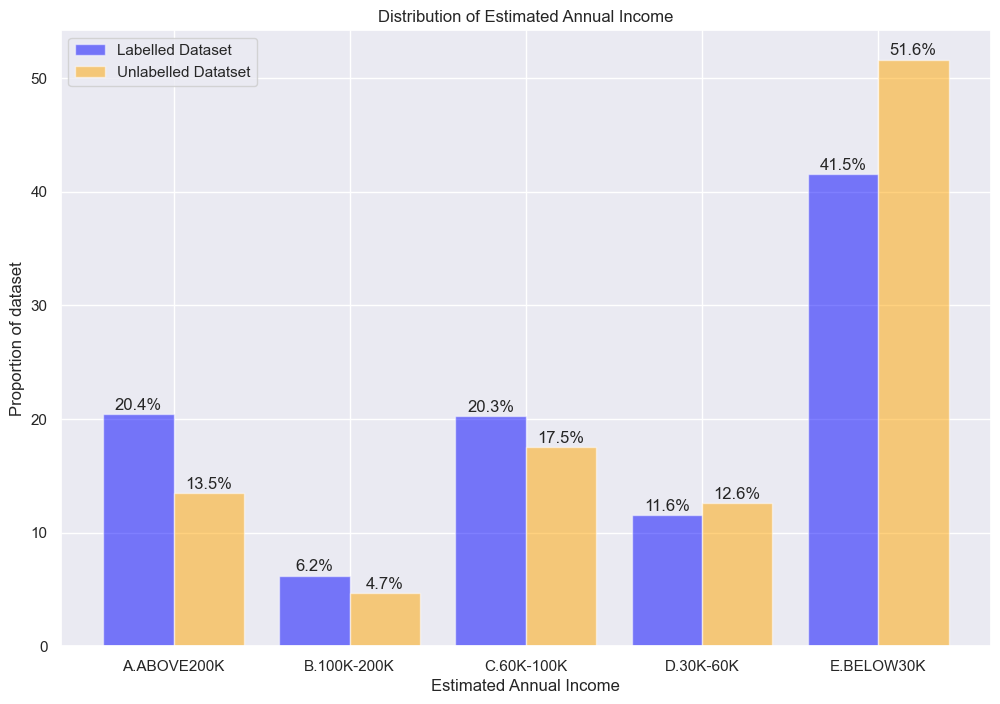

In [358]:
# Labelled Dataset
plot_bar_chart(labelled_df['annual_income_est'],unlabelled_df['annual_income_est'], 'Estimated Annual Income', 'Proportion of dataset', 'Distribution of Estimated Annual Income', dataset1_label='Labelled Dataset', dataset2_label='Unlabelled Datatset', whole_numbers_only = False, count_labels=True)

From the analysis conducted on the labeled dataset, which encompasses all customers who purchased policies in the next three months, an intriguing observation emerges: the income category contributing the most in terms of frequency is, unexpectedly, the lowest income category.

### Visualization 3: Policy Status

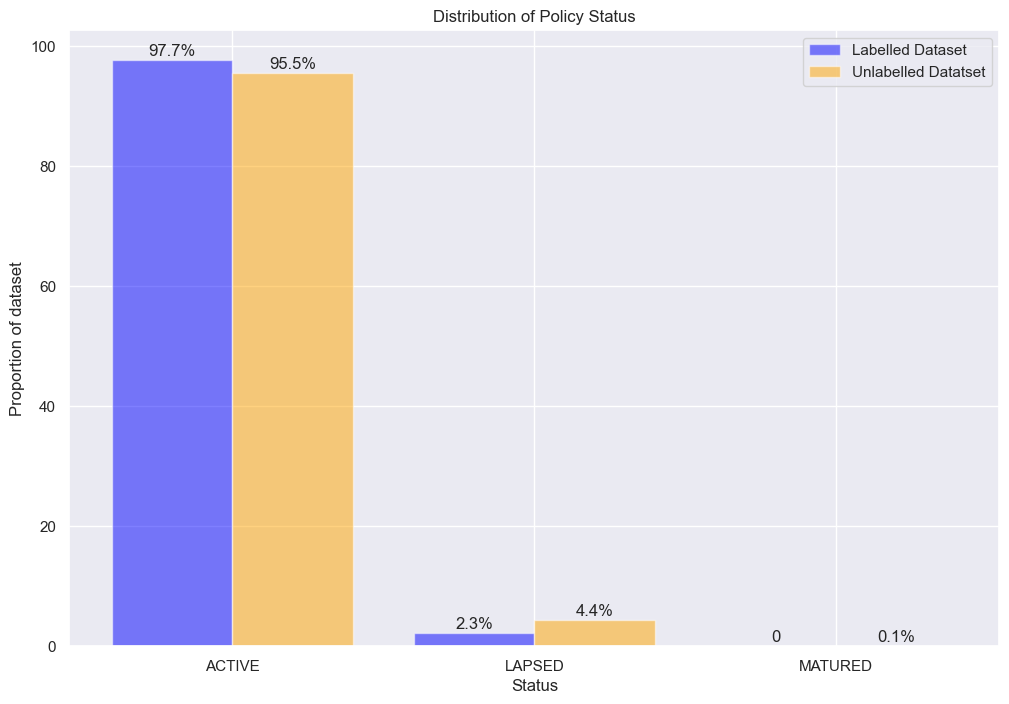

In [359]:
# Labelled Dataset
plot_bar_chart(labelled_df['stat_flag'],unlabelled_df['stat_flag'], 'Status', 'Proportion of dataset', 'Distribution of Policy Status', dataset1_label='Labelled Dataset', dataset2_label='Unlabelled Datatset', whole_numbers_only = False, count_labels=True)

Both the labelled and unlabelled dataset generally contains a large majority of Active Policies.

### Question 1: How does the risk status affect whether one purchases a policy in the future?

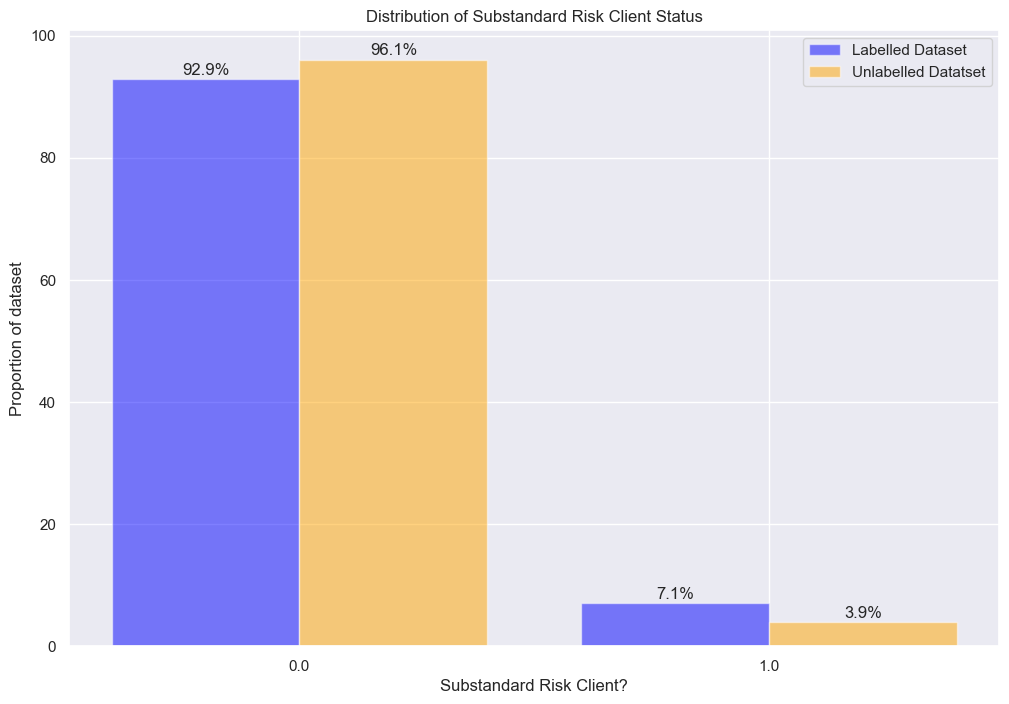

In [360]:
# Labelled Dataset
plot_bar_chart(labelled_df['flg_substandard'],unlabelled_df['flg_substandard'], 'Substandard Risk Client?', 'Proportion of dataset', 'Distribution of Substandard Risk Client Status', dataset1_label='Labelled Dataset', dataset2_label='Unlabelled Datatset', whole_numbers_only = False, count_labels=True)

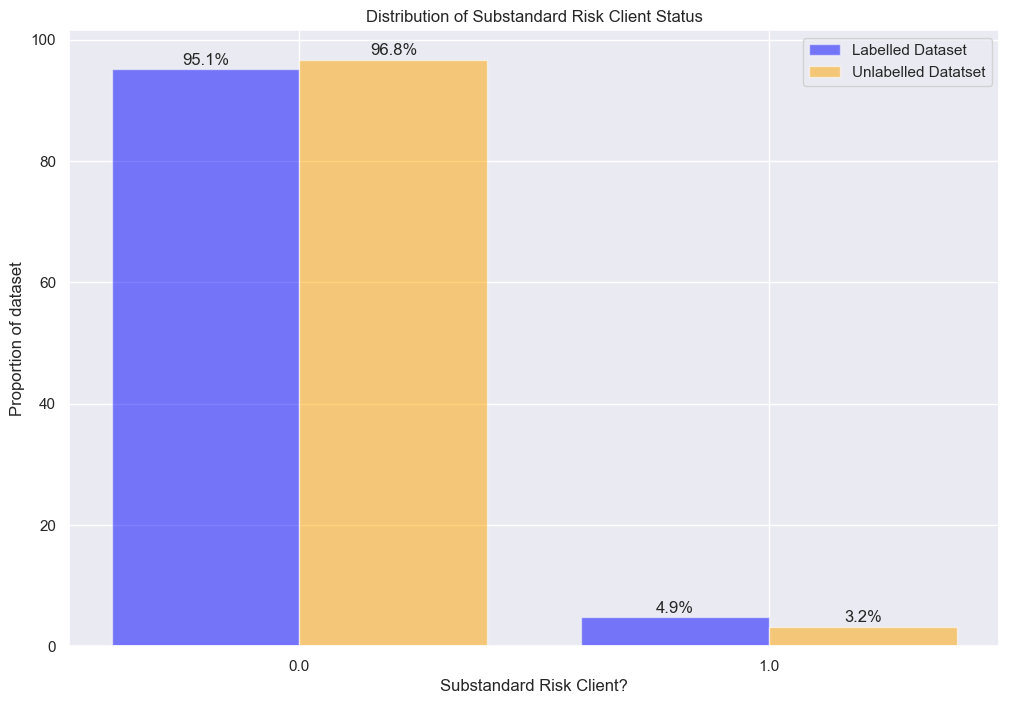

In [361]:
# Labelled Dataset
plot_bar_chart(labelled_df['flg_is_borderline_standard'],unlabelled_df['flg_is_borderline_standard'], 'Substandard Risk Client?', 'Proportion of dataset', 'Distribution of Substandard Risk Client Status', dataset1_label='Labelled Dataset', dataset2_label='Unlabelled Datatset', whole_numbers_only = False, count_labels=True)

As expected, clients with a borderline standard or a substandard status (value 1.0) will be much less likely to purchase a policy in the next 3 months.

### Question 2: What is the relationship between Inforce and Cancelled Policies?

In [362]:
def scatter_plot_inforce_vs_cancel(dataset1, dataset2, labels=('Dataset 1', 'Dataset 2')):
    # Replace NaN values with 0 and convert to integer datatype
    dataset1 = dataset1.fillna(0).astype({'tot_inforce_pols': float, 'tot_cancel_pols': float})
    dataset2 = dataset2.fillna(0).astype({'tot_inforce_pols': float, 'tot_cancel_pols': float})

    # Set up figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot for Dataset 1 (Blue)
    x1 = dataset1['tot_inforce_pols'].round().astype(int)
    y1 = dataset1['tot_cancel_pols'].round().astype(int)
    axs[0].scatter(x1, y1, alpha=0.5, label=labels[0], color='blue')
    axs[0].set_title(labels[0])
    axs[0].set_xlabel('Total In-force Policies')
    axs[0].set_ylabel('Total Canceled Policies')
    axs[0].legend()

    # Scatter plot for Dataset 2 (Orange)
    x2 = dataset2['tot_inforce_pols'].round().astype(int)
    y2 = dataset2['tot_cancel_pols'].round().astype(int)
    axs[1].scatter(x2, y2, alpha=0.5, label=labels[1], color='orange')
    axs[1].set_title(labels[1])
    axs[1].set_xlabel('Total In-force Policies')
    axs[1].set_ylabel('Total Canceled Policies')
    axs[1].legend()

    # Set individual scales for x-axis and y-axis in each subplot
    min_x = min(x1.min(), x2.min())
    max_x = max(x1.max(), x2.max())
    min_y = min(y1.min(), y2.min())
    max_y = max(y1.max(), y2.max())

    axs[0].set_xlim([min_x, max_x])
    axs[0].set_ylim([min_y, max_y])

    axs[1].set_xlim([min_x, max_x])
    axs[1].set_ylim([min_y, max_y])

    # Overall title
    fig.suptitle('Scatter Plot: Total In-force vs Total Canceled Policies')

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

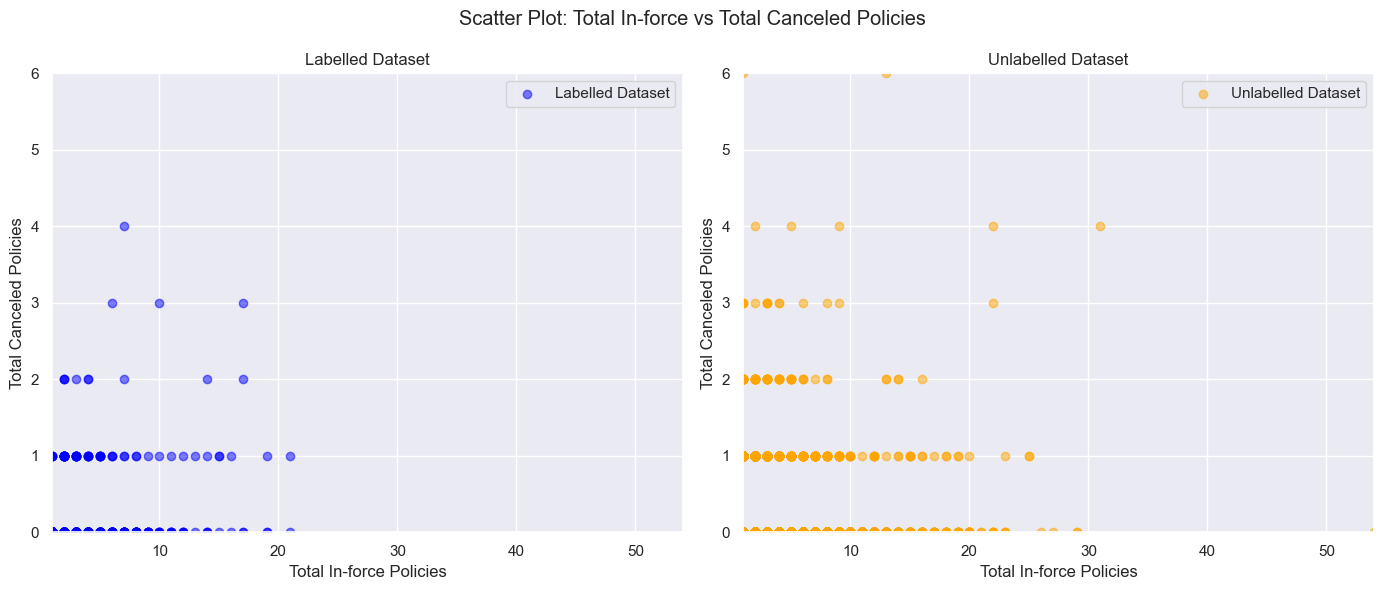

In [363]:
scatter_plot_inforce_vs_cancel(labelled_df[['tot_inforce_pols', 'tot_cancel_pols']], unlabelled_df[['tot_inforce_pols', 'tot_cancel_pols']], labels=('Labelled Dataset', 'Unlabelled Dataset'))

The distributions across the 2 datasets seem to be quite similar. A key thing to note would be that in the labelled dataset, there are no customers with more than 21 inforce polices.

### Question 3: How does consent preferences to marketing avenues(to email/mail/call/sms) affect whether or not a client purchases?

In [364]:
def visualize_consent_preferences_comparison(df1, df2):
    sns.set_theme()

    # Extract relevant columns
    consent_columns = ['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

    for i, df in enumerate([df1, df2]):
        # Plot for each DataFrame
        counts_df = df[consent_columns].apply(lambda x: x.value_counts(normalize=True) * 100).T
        counts_df.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[i])

        # Set labels and title
        if i == 0:
            axes[i].set_title(f'Labelled Dataset')
        elif i == 1:
            axes[i].set_title(f'Unlabelled Dataset')
        axes[i].set_xlabel('Consent Type')
        axes[i].set_ylabel('Percentage')

        # Rename the legend
        handles, labels = axes[i].get_legend_handles_labels()
        new_labels = ['No', 'Yes']
        axes[i].legend(handles, new_labels, title='Consent Preferences')

        # Update x-axis labels by removing common prefix
        new_labels = [label.get_text().split('_')[-1] for label in axes[i].get_xticklabels()]
        axes[i].set_xticklabels(new_labels)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

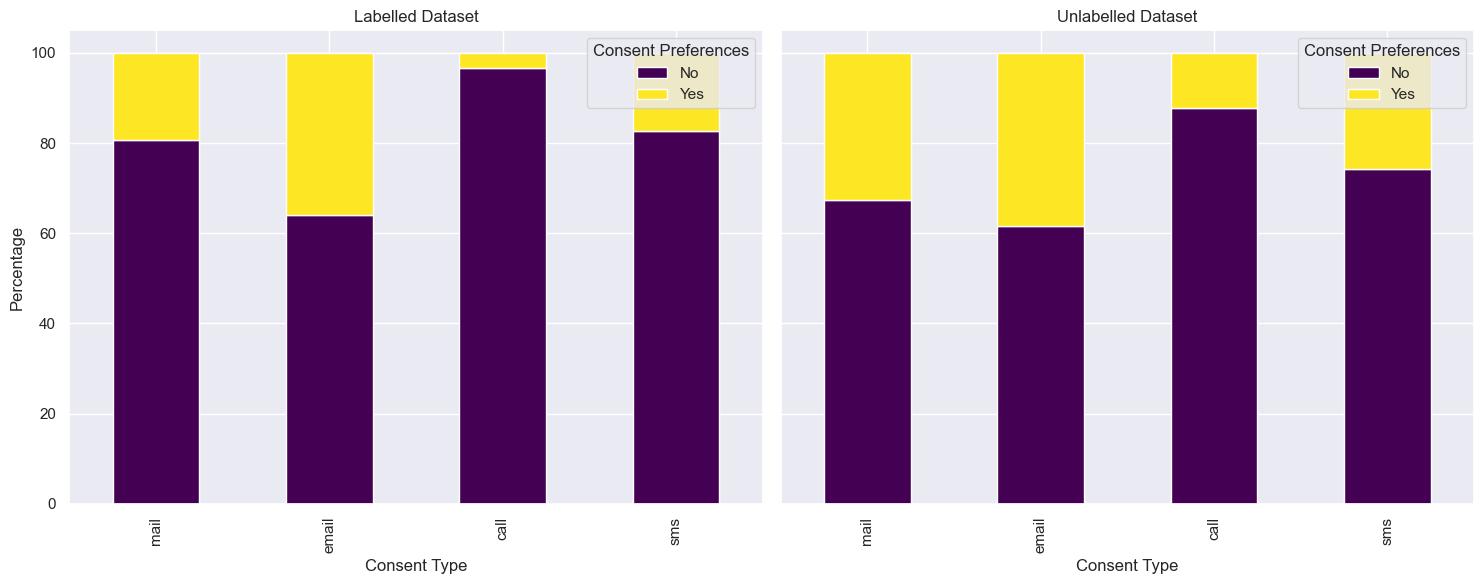

In [365]:
visualize_consent_preferences_comparison(labelled_df, unlabelled_df)

Comparing between the labelled and the unlabelled dataset, it is surprising to discover that within the labelled dataset (clients who purchased in the next 3 months), majority of the clients do not subscribe to marketing avenues like email/mail/call and sms. Additionally, the unlabelled dataset's distribution is very similar to that of the labelled dataset.

## Splitting of Dataset + Feature Engineering

### Splitting the Dataset into Train and Test

We will begin by partitioning the dataset into a training set and a testing set. This division serves the purpose of training and evaluating the performance of a machine learning model. The training set is utilized to train the model, enabling it to learn patterns and relationships within the data. On the other hand, the testing set is employed to assess the model's generalization capabilities by evaluating its performance on unseen data.

We will be using a split of 90% for the training set and 10% of the testing set.

One thing to note would be that a large proportion of the target columns are NaNs, as such we will write a special function to try and ensure the proportion of labelled vs unlabelled data in both training and test sets.

In [366]:
def split_dataset_with_nan_proportion(data, target_column, test_size=0.1, random_state=RANDOM_SEED):
    # Separate rows with non-NaN target values
    labeled_data = data.dropna(subset=[target_column])

    # Split the labeled data into training and testing sets
    train_labeled, test_labeled = train_test_split(
        labeled_data,
        test_size=test_size,
        random_state=random_state
    )

    # Calculate the proportion of NaNs in the original dataset
    nan_proportion = data[target_column].isna().mean()

    # Sample rows with NaN target values to maintain the same proportion
    nan_rows = data[data[target_column].isna()]

    # Split NaN rows into training and testing sets
    train_nan, test_nan = train_test_split(
        nan_rows,
        test_size=test_size,
        random_state=random_state
    )

    # Combine the labeled and NaN rows for both training and testing sets
    train_set = pd.concat([train_labeled, train_nan], ignore_index=True)
    test_set = pd.concat([test_labeled, test_nan], ignore_index=True)

    return train_set, test_set

In [367]:
train_df, test_df = split_dataset_with_nan_proportion(initial_df, 'f_purchase_lh', test_size=0.1, random_state=RANDOM_SEED)
print(train_df.shape)
print(test_df.shape)

(16192, 304)
(1800, 304)


In [368]:
def check_nan_proportions(train_data, test_data, target_column):
    def calculate_nan_proportion(data):
        total_rows = len(data)
        labeled_rows = data[target_column].count()
        nan_rows = total_rows - labeled_rows
        return nan_rows / labeled_rows if labeled_rows > 0 else 0.0

    nan_proportion_train = calculate_nan_proportion(train_data)
    nan_proportion_test = calculate_nan_proportion(test_data)

    print(f"Train Set - Proportion of NaN to Labeled in {target_column}: {nan_proportion_train:.4f}")
    print(f"Test Set - Proportion of NaN to Labeled in {target_column}: {nan_proportion_test:.4f}")

In [369]:
check_nan_proportions(train_df, test_df, 'f_purchase_lh')

Train Set - Proportion of NaN to Labeled in f_purchase_lh: 24.3396
Test Set - Proportion of NaN to Labeled in f_purchase_lh: 24.3521


### Creating a pipeline for feature engineering

We will create a function named `clean_data` that incorporates a data cleaning pipeline to refine our dataset. The following strategy will be employed:

1. **Handle Columns with 'Months' in their Names:**
   - Replace `None` values with 0 and 9999 with 0 for columns containing the word 'months'.

2. **Convert Categorical Columns to Strings:**
   - Ensure all categorical columns are converted to strings to meet encoder requirements.

2. **Convert Datetime columns to int**
   - For easier manipulation.

3. **Drop Specified Columns:**
   - Remove any columns specified for dropping, such as those identified through domain expertise.

4. **Drop Columns with More than 70% NaN Values:**
   - Apply the 70% rule to drop columns with excessive NaN values.

5. **Imputation and Winsorization for Numerical Columns:**
   - Utilize the median to impute missing values in numerical columns. Winsorization was used to prevent extreme anomalies from skewing the distribution excessively.

6. **Binary Conversion for Columns Starting with 'flg':**
   - Replace `None` values with 0 and perform one-hot encoding for binary conversion of columns starting with 'flg'.

7. **Imputation for Categorical Columns:**
   - Use the most frequently occurring label to impute missing values in categorical columns.

8. **One-Hot Encoding for Non-Binary Categorical Labels:**
   - Apply One-Hot Encoding specifically to non-binary categorical labels in the dataset.

9. **Drop Columns with Only One Unique Value**
   - Remove columns that provide no information because they only contain one unique value.

9. **Remove Highly Correlated Features**
   - Remove a minimal set of features such at correlation of all remaining features is below a pre-set correlation tolerance threshold (0.5)

   

In [370]:
# Define the columns that we will drop based on domain knowledge and statistical analysis
to_drop = ['clntnum', 'is_valid_dm', 'is_valid_email', 'giclaim_cnt_success', 'recency_giclaim_success', 'giclaim_cnt_unsuccess', 'recency_giclaim_unsuccess', 'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever']

In [371]:
# Define the correct mappings for columns
# Create the mapping dictionary
mapping_dict = {column: 'object' for column in train_df.columns}

# Identify the columns which are supposed to be float64
floats_columns = [column for column in train_df.columns if 'months' in column.lower() or 
                  column.startswith('hh') or column.startswith('ape_') or column.startswith('sumins_') or 
                  column.startswith('prempaid_') or column.startswith('lapse_')]
floats_columns.extend(['annual_income_est', 'pop_20', 'tot_inforce_pols'])
for column in floats_columns:
    mapping_dict[column] = 'float64'

# Identify the columns which are supposed to flags
flg_columns = [column for column in train_df.columns if column.startswith('flg_') or column.startswith('is_') or column.startswith('f_')]
flg_columns.extend(['f_ever_declined_la', 'race_desc', 'ctrycode_desc', 'cltsex_fix', 'clttype', 'stat_flag', 'f_purchase_lh'])
for column in flg_columns:
    mapping_dict[column] = 'category'

# Identify the columns which are supposed to be datetime
datetime_columns = ['min_occ_date', 'cltdob_fix']
for column in datetime_columns:
    mapping_dict[column] = 'datetime64[ns]'

In [372]:
correlation_threshold = 0.5

def get_highly_correlated_df(df, title):
    correlation_df = df[
        [key for key, value in mapping_dict.items() if 
        value == 'float64' and key in df.columns]].corr()
    sns.heatmap(correlation_df)
    plt.title(title)
    plt.show()
    highly_correlated_pairs = []

    # Iterate over the correlation DataFrame
    for i in range(len(correlation_df.columns)):
        for j in range(i+1, len(correlation_df.columns)):
            feature1 = correlation_df.columns[i]
            feature2 = correlation_df.columns[j]
            correlation = correlation_df.iloc[i, j]

            # Check if correlation is greater than threshold
            if abs(correlation) > correlation_threshold and feature1 != feature2:
                highly_correlated_pairs.append((feature1, feature2, correlation))

    # Create a new DataFrame from the highly correlated pairs list
    highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
    return correlation_df, highly_correlated_df

def remove_features_with_high_correlation(df, correlation_df, highly_correlated_df):
    # Create a set to keep track of features to remove
    features_to_remove = set()

    # Iterate through the highly correlated pairs
    for index, row in highly_correlated_df.iterrows():
        feature1, feature2, correlation = row['Feature 1'], row['Feature 2'], row['Correlation']
        # Check if either feature has already been marked for removal
        if feature1 not in features_to_remove and feature2 not in features_to_remove:
            # Decide which feature to keep based on average correlation
            avg_corr_feature1 = correlation_df.loc[feature1].mean()
            avg_corr_feature2 = correlation_df.loc[feature2].mean()
            # Keep the feature with lower average correlation
            if avg_corr_feature1 > avg_corr_feature2:
                features_to_remove.add(feature1)
            else:
                features_to_remove.add(feature2)

    # Remove the identified features from the dataset
    return df.drop(columns=features_to_remove), features_to_remove

We attempted to use PCA in our data cleaning pipeline, however we discovered that the model results were not as performant as without PCA, and hence we did not use PCA in creating our final models. We include the preprocessing functions for data cleaning with and without PCA below for completeness.

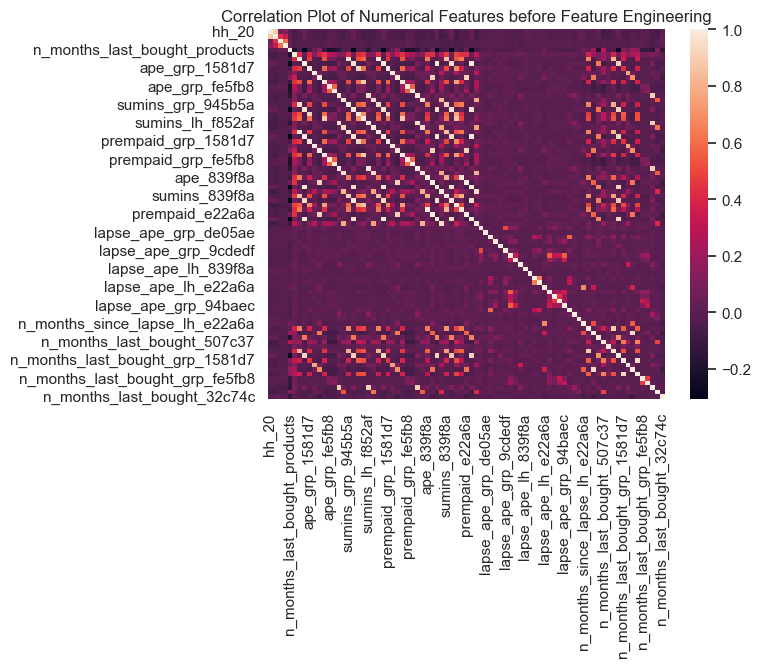

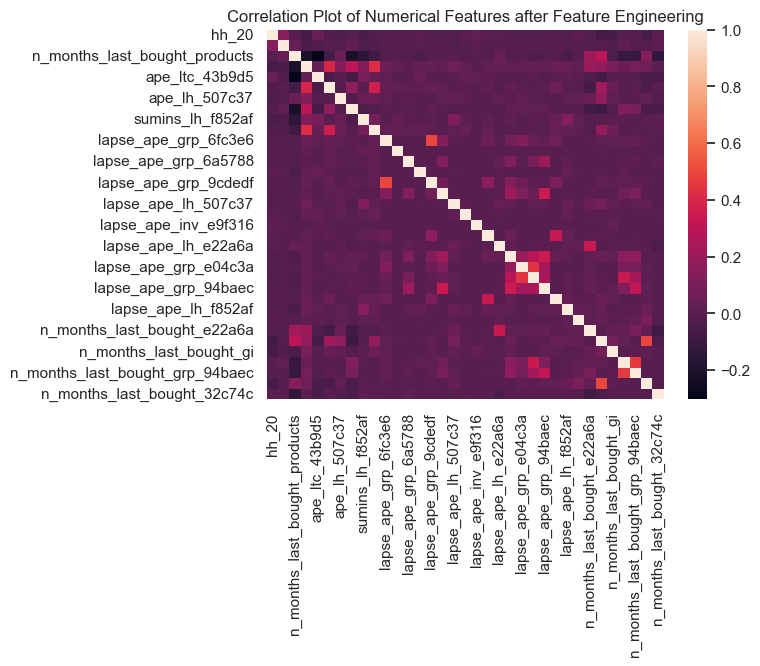

In [373]:
def clean_train_data(input_df, columns_to_drop=None, numerical_impute_strategy='median', 
                     categorical_impute_strategy='most_frequent', nan_threshold=0.7, column_data_types=None):
    train_configs = {
        'fn_configs': {},
        'cat_cols': [],
        'cat_ohe_cols': [],
        'drop': [],
        'final_cols': []
        }

    # Fill NaNs in the target column 'f_purchase_lh' with 0
    fn = lambda col: pd.to_numeric(col, errors='coerce').fillna(0).astype(int)
    input_df['f_purchase_lh'] = fn(input_df['f_purchase_lh'])

    # Convert columns to specified data types if column_data_types is not None:
    for col, data_type in column_data_types.items():
        if data_type == 'datetime64[ns]':
            fn = lambda col: pd.to_datetime(col, errors='coerce').astype('int64') // 10**9
            input_df[col] = fn(input_df[col])
            train_configs['fn_configs'][col] = [fn]
        
        elif data_type == 'float64':
            fn = lambda col: pd.Series(winsorize(pd.to_numeric(col, errors='coerce'), limits=[0.05, 0.05]))
            input_df[col] = fn(input_df[col])
            train_configs['fn_configs'][col] = [fn]

        elif data_type == 'category':
            # Assuming you want to convert to categorical type
            fn = lambda col: col.astype('category')
            input_df[col] = fn(input_df[col])
            train_configs['fn_configs'][col] = [fn]
            train_configs['cat_cols'].append(col)
        else:
            # Handle other data types as needed
            # You may want to add additional conditions for other data types
            train_configs['fn_configs'][col] = []

    # Drop specified columns
    if columns_to_drop is not None:
        input_df = input_df.drop(columns=columns_to_drop, errors='ignore')
        train_configs['drop'].extend(columns_to_drop)
    
    # Drop columns with more than 70% NaN values
    if nan_threshold is not None:
        columns_with_high_nan = input_df.columns[input_df.isna().mean() > nan_threshold]
        input_df = input_df.drop(columns=columns_with_high_nan)
        train_configs['drop'].extend(columns_with_high_nan)

    # Handle columns with 'months' in their names as numerical variables
    months_columns = [col for col in input_df.columns if 'months' in col.lower()]
    fn = lambda col: col.fillna(0).replace({None: 0, 9999: 0})
    for months_column in months_columns:
        input_df[months_column] = fn(input_df[months_column])
        train_configs['fn_configs'][months_column].append(fn)

    # Impute NaNs in numerical columns of type 'float64' with median
    numerical_columns = input_df.select_dtypes(include='float64').columns
    fn = lambda col: col.fillna(col.median())
    for numerical_column in numerical_columns:
        input_df[numerical_column] = fn(input_df[numerical_column])
        train_configs['fn_configs'][numerical_column].append(fn)

    # Impute NaNs in categorical columns of type 'category' with most frequent non-NaN value
    categorical_columns = input_df.select_dtypes(include='category').columns
    fn = lambda col: col.fillna(col.mode().iloc[0])
    for categorical_column in categorical_columns:
        input_df[categorical_column] = fn(input_df[categorical_column])
        train_configs['fn_configs'][categorical_column].append(fn)
    
    # Impute NaNs in datetime columns (converted to int) with median datetime (converted to int)
    datetime_columns = input_df.select_dtypes(include='datetime64[ns]').columns
    fn = lambda col: col.fillna(col.median())
    for datetime_column in datetime_columns:
        input_df[datetime_column] = fn(input_df[datetime_column])
        train_configs['fn_configs'][datetime_column].append(fn)

    # Perform One-Hot Encoding for categorical variables
    clean_df = pd.get_dummies(input_df, columns=categorical_columns, drop_first=True)
    train_configs['cat_ohe_cols'] = list(set(clean_df.columns) - set(input_df.columns))

    # Drop columns with only one value
    cols_to_drop = [col for col in clean_df.columns if clean_df[col].nunique() == 1]
    clean_df = clean_df.drop(columns=cols_to_drop)
    train_configs['drop'].extend(cols_to_drop)
    train_configs['final_cols'] = clean_df.columns

    # Drop highly correlated columns
    correlation_df, highly_correlated_df = get_highly_correlated_df(clean_df, 
                                                                    'Correlation Plot of Numerical Features before Feature Engineering')
    clean_df, features_with_high_correlation = remove_features_with_high_correlation(clean_df, correlation_df, highly_correlated_df)
    _, _ = get_highly_correlated_df(clean_df, 'Correlation Plot of Numerical Features after Feature Engineering')
    train_configs['drop'].extend(features_with_high_correlation)

    # PCA
    clean_df = clean_df.reset_index(drop=True)
    y = clean_df[['f_purchase_lh_1']].astype(int)
    pca = PCA(n_components=30)
    clean_df = pca.fit_transform(clean_df.drop(columns=['f_purchase_lh_1']))
    clean_df = pd.concat([pd.DataFrame(clean_df), y], axis=1)

    return clean_df, train_configs

def clean_train_data_without_pca(input_df, columns_to_drop=None, numerical_impute_strategy='median', 
                     categorical_impute_strategy='most_frequent', nan_threshold=0.7, column_data_types=None):
    train_configs = {
        'fn_configs': {},
        'cat_cols': [],
        'cat_ohe_cols': [],
        'drop': [],
        'final_cols': []
        }

    # Fill NaNs in the target column 'f_purchase_lh' with 0
    fn = lambda col: pd.to_numeric(col, errors='coerce').fillna(0).astype(int)
    input_df['f_purchase_lh'] = fn(input_df['f_purchase_lh'])

    # Convert columns to specified data types if column_data_types is not None:
    for col, data_type in column_data_types.items():
        if data_type == 'datetime64[ns]':
            fn = lambda col: pd.to_datetime(col, errors='coerce').astype('int64') // 10**9
            input_df[col] = fn(input_df[col])
            train_configs['fn_configs'][col] = [fn]
        
        elif data_type == 'float64':
            fn = lambda col: pd.Series(winsorize(pd.to_numeric(col, errors='coerce'), limits=[0.05, 0.05]))
            input_df[col] = fn(input_df[col])
            train_configs['fn_configs'][col] = [fn]

        elif data_type == 'category':
            # Assuming you want to convert to categorical type
            fn = lambda col: col.astype('category')
            input_df[col] = fn(input_df[col])
            train_configs['fn_configs'][col] = [fn]
            train_configs['cat_cols'].append(col)
        else:
            # Handle other data types as needed
            # You may want to add additional conditions for other data types
            train_configs['fn_configs'][col] = []

    # Drop specified columns
    if columns_to_drop is not None:
        input_df = input_df.drop(columns=columns_to_drop, errors='ignore')
        train_configs['drop'].extend(columns_to_drop)
    
    # Drop columns with more than 70% NaN values
    if nan_threshold is not None:
        columns_with_high_nan = input_df.columns[input_df.isna().mean() > nan_threshold]
        input_df = input_df.drop(columns=columns_with_high_nan)
        train_configs['drop'].extend(columns_with_high_nan)

    # Handle columns with 'months' in their names as numerical variables
    months_columns = [col for col in input_df.columns if 'months' in col.lower()]
    fn = lambda col: col.fillna(0).replace({None: 0, 9999: 0})
    for months_column in months_columns:
        input_df[months_column] = fn(input_df[months_column])
        train_configs['fn_configs'][months_column].append(fn)

    # Impute NaNs in numerical columns of type 'float64' with median
    numerical_columns = input_df.select_dtypes(include='float64').columns
    fn = lambda col: col.fillna(col.median())
    for numerical_column in numerical_columns:
        input_df[numerical_column] = fn(input_df[numerical_column])
        train_configs['fn_configs'][numerical_column].append(fn)

    # Impute NaNs in categorical columns of type 'category' with most frequent non-NaN value
    categorical_columns = input_df.select_dtypes(include='category').columns
    fn = lambda col: col.fillna(col.mode().iloc[0])
    for categorical_column in categorical_columns:
        input_df[categorical_column] = fn(input_df[categorical_column])
        train_configs['fn_configs'][categorical_column].append(fn)
    
    # Impute NaNs in datetime columns (converted to int) with median datetime (converted to int)
    datetime_columns = input_df.select_dtypes(include='datetime64[ns]').columns
    fn = lambda col: col.fillna(col.median())
    for datetime_column in datetime_columns:
        input_df[datetime_column] = fn(input_df[datetime_column])
        train_configs['fn_configs'][datetime_column].append(fn)

    # Perform One-Hot Encoding for categorical variables
    clean_df = pd.get_dummies(input_df, columns=categorical_columns, drop_first=True)
    train_configs['cat_ohe_cols'] = list(set(clean_df.columns) - set(input_df.columns))

    # Drop columns with only one value
    cols_to_drop = [col for col in clean_df.columns if clean_df[col].nunique() == 1]
    clean_df = clean_df.drop(columns=cols_to_drop)
    train_configs['drop'].extend(cols_to_drop)
    train_configs['final_cols'] = clean_df.columns

    # Drop highly correlated columns
    correlation_df, highly_correlated_df = get_highly_correlated_df(clean_df, 
                                                                    'Correlation Plot of Numerical Features before Feature Engineering')
    clean_df, features_with_high_correlation = remove_features_with_high_correlation(clean_df, correlation_df, highly_correlated_df)
    _, _ = get_highly_correlated_df(clean_df, 'Correlation Plot of Numerical Features after Feature Engineering')
    train_configs['drop'].extend(features_with_high_correlation)

    # PCA
    clean_df = clean_df.reset_index(drop=True)
    y = clean_df[['f_purchase_lh_1']].astype(int)
    # pca = PCA(n_components=30)
    # clean_df = pca.fit_transform(clean_df.drop(columns=['f_purchase_lh_1']))
    # clean_df = clean_df.drop(columns=["f_purchase_lh_1"])
    # clean_df = pd.concat([clean_df, y], axis=1)
    clean_df[["f_purchase_lh_1"]] = y

    return clean_df, train_configs

def clean_test_data(input_df, train_configs):
    input_df = input_df.copy()

    # Drop unnecessary columns
    input_df = input_df.drop(columns=[col for col in train_configs['drop'] if col in input_df.columns])

    # Apply functions
    for colname in input_df.columns:
        if colname in train_configs['fn_configs']:
            if colname == 'f_purchase_lh':
                fn = lambda col: pd.to_numeric(col, errors='coerce').fillna(0).astype(int)
                input_df[colname] = fn(input_df[colname])
            else:
                input_df[colname] = apply_fns(train_configs['fn_configs'][colname], input_df[colname])

    # Handle OHE
    input_df = pd.get_dummies(input_df, 
                              columns=list(set(train_configs['cat_cols']).intersection(input_df.columns)), 
                              drop_first=True)
    
    # Handle different columns resulting from OHE
    for col in train_configs['cat_ohe_cols']:
        if col not in input_df.columns:
            new_column = pd.Series(0, index=input_df.index, name=col)
            input_df = pd.concat([input_df, new_column], axis=1)
    
    input_df = input_df[[col for col in input_df.columns if col in train_configs['final_cols']]]

    y = input_df['f_purchase_lh_1'].astype(int)
    pca = PCA(n_components=30)
    input_df = pca.fit_transform(input_df.drop(columns=['f_purchase_lh_1']))
    input_df = pd.DataFrame(input_df)
    input_df['f_purchase_lh_1'] = y
    return input_df

def clean_test_data_without_pca(input_df, train_configs):
    input_df = input_df.copy()

    # Drop unnecessary columns
    input_df = input_df.drop(columns=[col for col in train_configs['drop'] if col in input_df.columns])

    # Apply functions
    for colname in input_df.columns:
        if colname in train_configs['fn_configs']:
            if colname == 'f_purchase_lh':
                fn = lambda col: pd.to_numeric(col, errors='coerce').fillna(0).astype(int)
                input_df[colname] = fn(input_df[colname])
            else:
                input_df[colname] = apply_fns(train_configs['fn_configs'][colname], input_df[colname])

    # Handle OHE
    input_df = pd.get_dummies(input_df, 
                              columns=list(set(train_configs['cat_cols']).intersection(input_df.columns)), 
                              drop_first=True)
    
    # Handle different columns resulting from OHE
    for col in train_configs['cat_ohe_cols']:
        if col not in input_df.columns:
            new_column = pd.Series(0, index=input_df.index, name=col)
            input_df = pd.concat([input_df, new_column], axis=1)
    
    input_df = input_df[[col for col in input_df.columns if col in train_configs['final_cols']]]

    y = input_df['f_purchase_lh_1'].astype(int)
    # pca = PCA(n_components=30)
    # input_df = pca.fit_transform(input_df.drop(columns=['f_purchase_lh_1']))
    # input_df = pd.DataFrame(input_df)
    input_df['f_purchase_lh_1'] = y
    return input_df

def apply_fns(fn_list, elem):
    for fn in fn_list:
        elem = fn(elem)
    return elem

clean_train_df, train_configs = clean_train_data_without_pca(train_df, columns_to_drop=to_drop, column_data_types=mapping_dict)
clean_test_df = clean_test_data_without_pca(test_df, train_configs)

After the recent adjustments, our dataset now retains a reduced set of 18 numerical features. A glance at the correlation plot reinforces our selection, indicating that these 18 columns exhibit minimal correlation with each other. This outcome aligns with our objective of maintaining a set of diverse and non-redundant features, enhancing the suitability of the dataset for subsequent analysis or modeling.

In [374]:
print(clean_train_df.shape)
print(clean_test_df.shape)
print(set(clean_train_df.columns) - set(clean_test_df.columns))
print(set(clean_test_df.columns) - set(clean_train_df.columns))

(16192, 126)
(1800, 126)
set()
set()


In [375]:
# Check for NaN values and the number of unique values
nulls_exist = clean_train_df.isnull().values.any()
print("Are there any NaN values: ", nulls_exist)

if nulls_exist:
    # Count the number of NaN values in each column
    nan_count_per_column = clean_train_df.isnull().sum()
    
    # Display the count of NaN values in descending order
    nan_count_per_column_sorted = nan_count_per_column.sort_values(ascending=False)
    
    print("Number of NaN values in each column (descending order):")
    print(nan_count_per_column_sorted[nan_count_per_column_sorted != 0])

Are there any NaN values:  False


In [376]:
clean_test_df.f_purchase_lh_1.value_counts()

f_purchase_lh_1
0    1729
1      71
Name: count, dtype: int64

In [377]:
test_df.f_purchase_lh.value_counts()

f_purchase_lh
1.0    71
Name: count, dtype: int64

In [378]:
clean_train_df.f_purchase_lh_1.value_counts()

f_purchase_lh_1
0    15553
1      639
Name: count, dtype: int64

In [379]:
train_df.f_purchase_lh.value_counts()

f_purchase_lh
0    15553
1      639
Name: count, dtype: int64

Upon comparing the structure of the datasets before and after implementing feature engineering, it is evident that we have effectively preserved the overall shape of the dataset while handling NaN values. Moving forward, these two refined datasets will serve as our basis for model training and evaluation.

## Modelling
We now move on to modelling. From the data, we can predict that gradient boosting and random forests might work well. Moreover, given the highly imbalanced nature of the dataset, it would be best to try to oversample the minority labels, as well as to try stratified k-fold cross-validation.

In [380]:

target_col = "f_purchase_lh_1"

In [381]:
over_sampler = RandomOverSampler(random_state=RANDOM_SEED)
X = clean_train_df[clean_train_df.columns.difference([target_col])]
y = clean_train_df[target_col]
X_over, y_over = over_sampler.fit_resample(X, y)

### Model Evaluation Functions

In addition, in the following few blocks, we will write some model evaluation functions that will help us to visualize our model's performance.

In [382]:
# Function to plot the average confusion_matrix after cross-validation 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm) # Print the raw confusion matrix 

    # Create plot 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [383]:
# Function to plot ROC Curve for each Cross Validation Fold 
def plot_roc(y_test_lst, y_pred_lst):
    fpr, tpr, _ = roc_curve(y_test_lst, y_pred_lst)
    plt.plot(fpr, tpr, label = 'ROC=%.4f' % (roc_auc_score(y_test_lst, y_pred_lst)))
    plt.title(f'Receiver Operating Characteristic (ROC) Curve')
    plt.plot([0, 1], ls="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

In [384]:
# Function to plot Precision Recall Curve for each Cross Validation Fold 
def plot_precision_recall(y_test_lst, y_pred_lst):
    precision, recall, thresholds = precision_recall_curve(y_test_lst, y_pred_lst)
    plt.plot(recall, precision, label = 'AUC=%.4f' % (auc(recall, precision)))
    plt.plot([0, 1], [0.5, 0.5], linestyle = '--')  #baseline 
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 22)
    plt.legend()
    plt.show()

### Model 1: Logistic Regression

We first created a baseline logistic regression model so that we have a reference point to compare with. This is due to the simplicity of implementing logistic regression, as well as its flexibility in classification tasks.

In [385]:
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression(class_weight="balanced")
lreg.fit(clean_train_df[clean_train_df.columns.difference([target_col])], clean_train_df[target_col])
y_pred = lreg.predict(clean_test_df[clean_test_df.columns.difference([target_col])])
print(accuracy_score(clean_test_df[target_col], y_pred))
print(f1_score(clean_test_df[target_col], y_pred, average="weighted"))

0.8244444444444444
0.8722135229827331


In [386]:
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression(max_iter=200)
lreg.fit(X_over, y_over)
y_pred = lreg.predict(clean_test_df[clean_test_df.columns.difference([target_col])])
print(accuracy_score(clean_test_df[target_col], y_pred))
print(f1_score(clean_test_df[target_col], y_pred, average="weighted"))

0.8238888888888889
0.8718720575320889


### Model 2: Neural Network

We then wanted to observe whether having a neural network model would improve performance. After several rounds of hyperparameter tuning, we came up with the below model architecture that yields the best performance using this type of model.

In [387]:
import torch
import torch.nn as nn

In [388]:
class PolicyDataset(torch.utils.data.Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.Series):
        self.X = torch.tensor(X.values.astype(np.float64)).type(torch.float32)
        self.y = torch.tensor(y.values.astype(np.float64)).type(torch.float32).unsqueeze(dim=-1)
    
    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]


In [389]:
class PolicyClassifier(nn.Module):
    def __init__(self, dim_in: int = clean_train_df.shape[1] - 1, dim_out: int = 1, hidden_dim: int = 768):
        super().__init__()
        self.linear_1 = nn.Linear(dim_in, hidden_dim)
        self.dropout_1 = nn.Dropout(p=0.4)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout_2 = nn.Dropout(p=0.4)
        self.linear_3 = nn.Linear(hidden_dim, dim_out)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)
        x = self.sigmoid(x)
        return x


In [390]:
clean_train_df.dtypes.value_counts()

bool       87
float64    27
int64      12
Name: count, dtype: int64

In [391]:
clean_train_df.to_numpy().astype("float32")

array([[ 1.4516064e+09,  7.9522560e+08,  5.0000000e+01, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 1.3429152e+09, -5.4025920e+08,  1.0300000e+02, ...,
         0.0000000e+00,  1.0000000e+00,  1.0000000e+00],
       [ 1.5991776e+09,  6.6968640e+08,  1.4400000e+02, ...,
         0.0000000e+00,  1.0000000e+00,  1.0000000e+00],
       ...,
       [ 1.3982112e+09, -1.6156800e+08,  1.1200000e+02, ...,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [ 1.4342400e+09,  4.1402880e+08,  1.6000000e+01, ...,
         1.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [ 1.4292288e+09, -4.0098240e+08,  1.0000000e+00, ...,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00]], dtype=float32)

In [392]:
clf = PolicyClassifier()
X_test, y_test = clean_test_df[clean_test_df.columns.difference([target_col])], clean_test_df[target_col]
train_dataset = PolicyDataset(X_over, y_over)
test_dataset = PolicyDataset(X_test, y_test)
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)
loss_fn = nn.BCELoss()
optim = torch.optim.AdamW(clf.parameters())

In [393]:
train_ls = []
test_ls = []

In [394]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    clf.train()
    for idx, (X_batch, y_batch) in enumerate(train_dataloader):
        pred = clf(X_batch)
        loss = loss_fn(pred, y_batch)


        y_numpy = y_batch.detach().numpy()
        pred_numpy = pred.detach().numpy()
        acc = accuracy_score(y_numpy, pred_numpy.round()) 
        f1 = f1_score(y_numpy, pred_numpy.round(), zero_division=0.0)
        train_ls.append((acc, f1))
        optim.zero_grad()
        loss.backward()
        optim.step()

    clf.eval()
    with torch.inference_mode():
        for idx, (X_batch, y_batch) in enumerate(test_dataloader):
            pred = clf(X_batch)
            loss = loss_fn(pred, y_batch)

            y_numpy = y_batch.detach().numpy()
            pred_numpy = pred.detach().numpy()
            acc = accuracy_score(y_numpy, pred_numpy.round()) 
            f1 = f1_score(y_numpy, pred_numpy.round(), zero_division=0.0)
            test_ls.append((acc, f1))

        



Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


In [395]:
test_preds = {"true": [], "pred": []}
with torch.inference_mode():
    for idx, (X_batch, y_batch) in enumerate(test_dataloader):
        pred = clf(X_batch)
        test_preds["true"].append(y_batch.detach().numpy().squeeze())
        test_preds["pred"].append(pred.detach().numpy().squeeze())

In [396]:
from functools import reduce
test_preds_true = list(reduce(lambda a, b: a + b, list(map(lambda x: x.flatten().tolist(), test_preds["true"]))))
test_preds_pred = list(reduce(lambda a, b: a + b, list(map(lambda x: x.flatten().tolist(), test_preds["pred"]))))


In [397]:
test_preds_df = pd.DataFrame({"true": test_preds_true, "pred": test_preds_pred})

In [398]:
print(accuracy_score(test_preds_df["true"], test_preds_df["pred"]))
print(f1_score(test_preds_df["true"], test_preds_df["pred"], average="weighted"))

0.04666666666666667
0.01839709875566804


### Model 3: XGBoost

As the dataset is highly imbalanced and has a number of features, we decided that XGBoost could be a good model to try out. We trained the model using `StratifiedKFold` due to the imbalanceness found in the dataset. Moreover, we gathered important features and dropped the less important ones. Moreover, our `learning_rate` parameter was based on a few rounds of hyperparameter tuning that aimed to optimise the F1 score on our custom-made test set.

In [399]:
def create_xgb_classifier_feature_importance(
        X: pd.DataFrame, 
        y: pd.Series, 
        n_splits: int = 30):
    '''
    Used to run a preliminary XGBModel, and to find the feature importance
    '''
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    model = XGBClassifier(learning_rate=0.001, tree_method="hist", reg_lambda=10, random_state=RANDOM_SEED)
    model.fit(X, y)
    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {idx + 1}")
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val, y_val = X.iloc[val_idx,:], y[val_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_val)

        acc_score = accuracy_score(y_val, pred)
        f1 = f1_score(y_val, pred, average="weighted")
        print(f"Accuracy: {acc_score} | F1 Score: {f1}")
        # Print a classification report
        # report = classification_report(y_val, pred)
        # print(report)
        # xgb.plot_importance(model)
        feature_importance = model.get_booster().get_score(importance_type='weight')

        # Sort the feature importance dictionary by values (importance scores)
        sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

        # Extract feature names and importance scores into separate lists
        feature_names, importance_scores = zip(*sorted_feature_importance)

    # model.save_model("xgb_model.json")
    print(feature_names)
    print(importance_scores)
    return feature_names

def create_xgb_classifier(
        X: pd.DataFrame, 
        y: pd.Series, 
        n_splits: int = 30):
    '''
    Used to run an XGBModel
    '''
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    model = XGBClassifier(learning_rate=0.001, tree_method="hist", reg_lambda=10, random_state=RANDOM_SEED)
    model.fit(X, y)
    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {idx + 1}")
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val, y_val = X.iloc[val_idx,:], y[val_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_val)

        acc_score = accuracy_score(y_val, pred)
        f1 = f1_score(y_val, pred, average="weighted")
        print(f"Accuracy: {acc_score} | F1 Score: {f1}")

    model.save_model("xgb_model.json")




In [400]:
ranked_features = create_xgb_classifier_feature_importance(X_over, y_over)

Fold: 1
Accuracy: 0.7743490838958534 | F1 Score: 0.7740990945181128
Fold: 2
Accuracy: 0.789778206364513 | F1 Score: 0.7894245468525285
Fold: 3
Accuracy: 0.76374156219865 | F1 Score: 0.7637217873707677
Fold: 4
Accuracy: 0.76374156219865 | F1 Score: 0.7632020432335076
Fold: 5
Accuracy: 0.7984570877531341 | F1 Score: 0.7983858426226662
Fold: 6
Accuracy: 0.7656702025072324 | F1 Score: 0.7655284742477477
Fold: 7
Accuracy: 0.7753134040501446 | F1 Score: 0.7749869734215069
Fold: 8
Accuracy: 0.7830279652844745 | F1 Score: 0.7827439019832103
Fold: 9
Accuracy: 0.7685631629701061 | F1 Score: 0.7683356642733943
Fold: 10
Accuracy: 0.759884281581485 | F1 Score: 0.7588008696191009
Fold: 11
Accuracy: 0.7656702025072324 | F1 Score: 0.7655284742477477
Fold: 12
Accuracy: 0.7627772420443587 | F1 Score: 0.7627428235638518
Fold: 13
Accuracy: 0.781099324975892 | F1 Score: 0.780897202315458
Fold: 14
Accuracy: 0.7762777242044359 | F1 Score: 0.7760965857139153
Fold: 15
Accuracy: 0.7733847637415622 | F1 Score: 0

In [401]:
# List of important features 
important_features = list(ranked_features[:30])
print(important_features)


['cltdob_fix', 'min_occ_date', 'n_months_last_bought_products', 'is_class_1_2_1.0', 'is_housewife_retiree_1.0', 'is_consent_to_mail_1.0', 'hh_20', 'n_months_last_bought_gi', 'tot_inforce_pols', 'ape_ltc_43b9d5', 'f_ever_bought_grp_70e1dd_1', 'flg_is_proposal_1.0', 'is_consent_to_email_1.0', 'lapse_ape_lh_e22a6a', 'n_months_last_bought_507c37', 'prempaid_839f8a', 'recency_lapse', 'is_sg_pr_1.0', 'clttype_G', 'n_months_last_bought_e22a6a', 'f_hold_507c37_1', 'flg_with_preauthorisation_1.0', 'lapse_ape_grp_94baec', 'n_months_last_bought_32c74c', 'race_desc_Malay', 'f_hold_e22a6a_1']


In [402]:
# Run XGB with selected features 
X_over_selected = X_over[important_features]
create_xgb_classifier(X_over_selected, y_over)

Fold: 1
Accuracy: 0.7733847637415622 | F1 Score: 0.7732477014330071
Fold: 2
Accuracy: 0.7849566055930569 | F1 Score: 0.7838106114175906
Fold: 3
Accuracy: 0.76374156219865 | F1 Score: 0.7636888216727031
Fold: 4
Accuracy: 0.7569913211186113 | F1 Score: 0.7555907222387137
Fold: 5
Accuracy: 0.7849566055930569 | F1 Score: 0.784197599393811
Fold: 6
Accuracy: 0.7647058823529411 | F1 Score: 0.7641901057736715
Fold: 7
Accuracy: 0.7656702025072324 | F1 Score: 0.7643540101321952
Fold: 8
Accuracy: 0.7762777242044359 | F1 Score: 0.7751170178759447
Fold: 9
Accuracy: 0.7608486017357763 | F1 Score: 0.7593986677338299
Fold: 10
Accuracy: 0.7579556412729026 | F1 Score: 0.7569861196154258
Fold: 11
Accuracy: 0.7656702025072324 | F1 Score: 0.7655284742477477
Fold: 12
Accuracy: 0.7618129218900676 | F1 Score: 0.7610262017512044
Fold: 13
Accuracy: 0.7791706846673095 | F1 Score: 0.778339539105514
Fold: 14
Accuracy: 0.7627772420443587 | F1 Score: 0.7618271497769981
Fold: 15
Accuracy: 0.7656702025072324 | F1 Scor

In [403]:
def test_xgb_model(fname: str) -> None:
    xgb_model = XGBClassifier()
    xgb_model.load_model(fname)
    X_test, y_test = clean_test_df[clean_test_df.columns.difference([target_col])], clean_test_df[target_col]
    pred = xgb_model.predict(X_test)
    acc_score = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average="weighted")
    print(f"Accuracy: {acc_score} | F1 Score: {f1}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, pred)

    return cm, y_test, pred

def test_xgb_model_reduced(fname: str) -> None:
    xgb_model = XGBClassifier()
    xgb_model.load_model(fname)
    X_test, y_test = clean_test_df[clean_test_df.columns.difference([target_col])], clean_test_df[target_col]
    X_test = clean_test_df[important_features]
    pred = xgb_model.predict(X_test)
    acc_score = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average="weighted")
    print(f"Accuracy: {acc_score} | F1 Score: {f1}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, pred)

    return cm, y_test, pred

In [404]:
cm, y_test, pred = test_xgb_model_reduced("xgb_model.json")

Accuracy: 0.7216666666666667 | F1 Score: 0.8066138141119695


[[0.72643146 0.27356854]
 [0.3943662  0.6056338 ]]


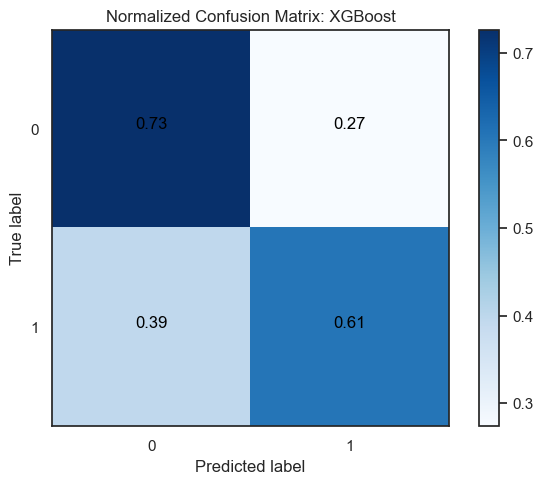

In [405]:
# Plot confusion matrix
sns.set_style('white')
class_names = ['0','1']
plot_confusion_matrix(cm,
                      classes= class_names, normalize = True,
                      title='Normalized Confusion Matrix: XGBoost')

As we can see from the confusion matrix, the XGBoost yields superior performance (based on F1 score) on our test set compared to other models. This may be due to the flexible nature of XGBoost, as well as our use of `StratifiedKFold` on the dataset. As seen from the above confusion matrix, it achieves our target of minimizing the False Negative Rate (FNR), which will usually happen due to the imbalancedness of the dataset. At the same time, it continues to maximize the True Negative Rate (TNR).

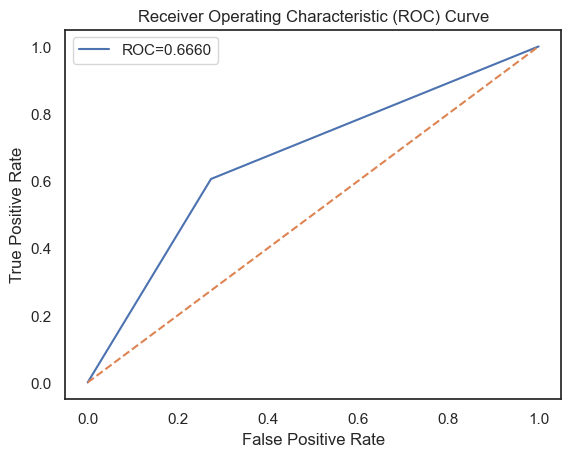

In [406]:
# Plot the ROC curve
plot_roc(y_test, pred)

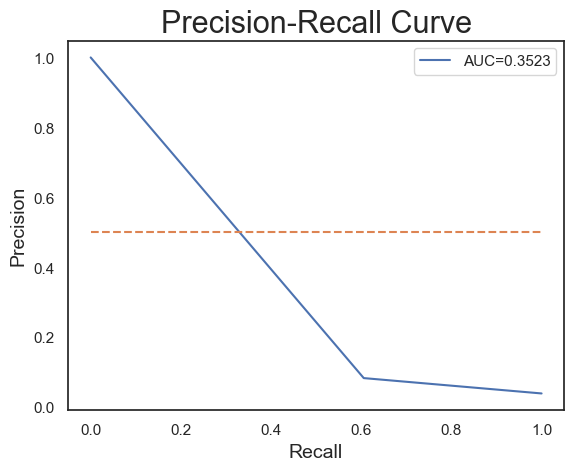

In [407]:
# Plot the Precision Recall Curve
plot_precision_recall(y_test.to_list(), pred)

In [408]:
# Print the Classification Report
scores = classification_report(y_test, pred)
print(scores)

              precision    recall  f1-score   support

           0       0.98      0.73      0.83      1729
           1       0.08      0.61      0.15        71

    accuracy                           0.72      1800
   macro avg       0.53      0.67      0.49      1800
weighted avg       0.94      0.72      0.81      1800



## Conclusion
In conclusion, the cleaning of the dataset was the most challenging part of the project, as it involved multiple processing steps and analyses. Due to the nature of the datathon, we were unable to explore more models that might have better performance. However, as shown by the XGBoost model, we can see that such a model shows great promise and would be good for further development.

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [409]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

    The function accepts a dataframe as input and return an iterable (list)
    of binary classes as output.

    The function should be coded to test on hidden data
    and should include any preprocessing functions needed for your model to perform. 
        
    All relevant code MUST be included in this function.
    '''

    test_data = clean_test_data_without_pca(hidden_data, train_configs)
    xgb = XGBClassifier()
    xgb.load_model("xgb_model.json")
    X_test = test_data[test_data.columns.difference([target_col])]
    X_test = test_data[important_features]
    pred = xgb.predict(X_test)

    return pred

##### Cell to check testing_hidden_data function

In [410]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[0 0 1 ... 0 0 1]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!